<a href="https://colab.research.google.com/github/tamara-kostova/MSc_Thesis_Neuroimaging/blob/master/05_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
BASE_DIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging"
RESULTS_DIR = f"{BASE_DIR}/results"
results_path = f"{BASE_DIR}/results/benchmarks/benchmark_results_20260110_212727.json"

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

with open(results_path, 'r') as f:
    all_results = json.load(f)
summary_data = []
for dataset_name, models in all_results.items():
    for model_name, results in models.items():
        if 'test_metrics' in results:
            row = {
                'dataset': dataset_name,
                'model': model_name,
                'accuracy': results['test_metrics']['accuracy'],
                'auc': results['test_metrics']['auc'],
            }
            summary_data.append(row)

df = pd.DataFrame(summary_data)
df['accuracy_pct'] = (df['accuracy'] * 100).round(1)

print(f"\n Loaded {len(df)} results")
print(df.sort_values('accuracy_pct', ascending=False).head(10)[['model', 'dataset', 'accuracy_pct']])



 Loaded 32 results
              model                dataset  accuracy_pct
1         resnet101  MRI_tumor_binary_norm          99.6
5      mobilenet_v2  MRI_tumor_binary_norm          98.7
4       densenet169  MRI_tumor_binary_norm          98.2
0          resnet50  MRI_tumor_binary_norm          98.2
2             vgg16  MRI_tumor_binary_norm          98.0
3       densenet121  MRI_tumor_binary_norm          97.8
6   efficientnet_b0  MRI_tumor_binary_norm          95.3
27      densenet121  CT_stroke_binary_norm          92.0
25        resnet101  CT_stroke_binary_norm          91.2
24         resnet50  CT_stroke_binary_norm          91.0


In [68]:
def create_table(df):
    dataset_order = {
        'MRI_tumor_binary_norm': 'Tumor\nBinary',
        'MRI_tumor_multiclass_norm': 'Tumor\nMulti',
        'MRI_ms_norm': 'MS\nBinary',
        'CT_stroke_binary_norm': 'Stroke\nBinary'
    }

    model_order = [
        'resnet50', 'resnet101', 'vgg16', 'densenet121',
        'densenet169', 'mobilenet_v2', 'efficientnet_b0', 'efficientnet_b4'
    ]
    model_display = {
        'resnet50': 'ResNet50',
        'resnet101': 'ResNet101',
        'vgg16': 'VGG16',
        'densenet121': 'DenseNet121',
        'densenet169': 'DenseNet169',
        'mobilenet_v2': 'MobileNetV2',
        'efficientnet_b0': 'EffNet-B0',
        'efficientne_tb4': 'EffNet-B4'
    }

    datasets_display = [dataset_order.get(d, d) for d in dataset_order.keys()]
    header = "| Model | " + " | ".join(datasets_display) + " |"
    separator = "|-------|" + "|------|" * len(datasets_display)

    table_lines = [header, separator]

    for model in model_order:
        row = f"| {model_display.get(model, model):<7} |"
        for dataset in dataset_order.keys():
            acc = df[(df['model'] == model) & (df['dataset'] == dataset)]['accuracy_pct']
            if len(acc) > 0:
                row += f" {acc.iloc[0]}% |"
            else:
                row += " - |"
        table_lines.append(row)

    return "\n".join(table_lines)

In [69]:
table = create_table(df)
print(f"\n{'='*70}")
print("## TABLE")
print(f"{'='*70}")
print(table)


## TABLE
| Model | Tumor
Binary | Tumor
Multi | MS
Binary | Stroke
Binary |
|-------||------||------||------||------|
| ResNet50 | 98.2% | 81.5% | 67.6% | 91.0% |
| ResNet101 | 99.6% | 82.0% | 65.4% | 91.2% |
| VGG16   | 98.0% | 76.1% | 68.1% | 83.4% |
| DenseNet121 | 97.8% | 85.3% | 67.9% | 92.0% |
| DenseNet169 | 98.2% | 84.3% | 65.0% | 85.5% |
| MobileNetV2 | 98.7% | 78.4% | 68.1% | 90.4% |
| EffNet-B0 | 95.3% | 73.6% | 66.4% | 89.2% |
| efficientnet_b4 | 84.7% | 51.7% | 68.6% | 82.5% |


In [70]:
import os
table_path = os.path.join(RESULTS_DIR, "THESIS_TABLE.md")
summary_path = os.path.join(RESULTS_DIR, "model_summary.csv")

In [71]:
with open(table_path, "w") as f:
    f.write(table)
df.to_csv(summary_path, index=False)

In [72]:
print(f"\n## BEST MODELS BY DATASET")
best = df.loc[df.groupby('dataset')['accuracy'].idxmax()][['dataset', 'model', 'accuracy_pct']]
print(best.round(1).to_markdown(index=False))


## BEST MODELS BY DATASET
| dataset                   | model           |   accuracy_pct |
|:--------------------------|:----------------|---------------:|
| CT_stroke_binary_norm     | densenet121     |           92   |
| MRI_ms_norm               | efficientnet_b4 |           68.6 |
| MRI_tumor_binary_norm     | resnet101       |           99.6 |
| MRI_tumor_multiclass_norm | densenet121     |           85.3 |


In [73]:
data = []
for dataset, models in all_results.items():
    for model, results in models.items():
        if 'test_metrics' in results:
            data.append({
                'dataset': dataset,
                'model': model,
                'accuracy': results['test_metrics']['accuracy'] * 100,
                'auc': results['test_metrics']['auc'] * 100,
                'f1': results['test_metrics']['f1'] * 100
            })

df = pd.DataFrame(data)

In [74]:
df['model_short'] = df['model'].map({
    'resnet50': 'ResNet50', 'resnet101': 'ResNet101',
    'vgg16': 'VGG16', 'densenet121': 'DN121', 'densenet169': 'DN169',
    'mobilenet_v2': 'MobileNet', 'efficientnet_b0': 'EffNet-B0',
    'efficientnet_b4': 'EffNet-B4'
})

df['dataset_short'] = df['dataset'].map({
    'MRI_tumor_binary_norm': 'Tumor Binary',
    'MRI_tumor_multiclass_norm': 'Tumor Multi',
    'MRI_ms_norm': 'MS Binary',
    'CT_stroke_binary_norm': 'Stroke Binary'
})

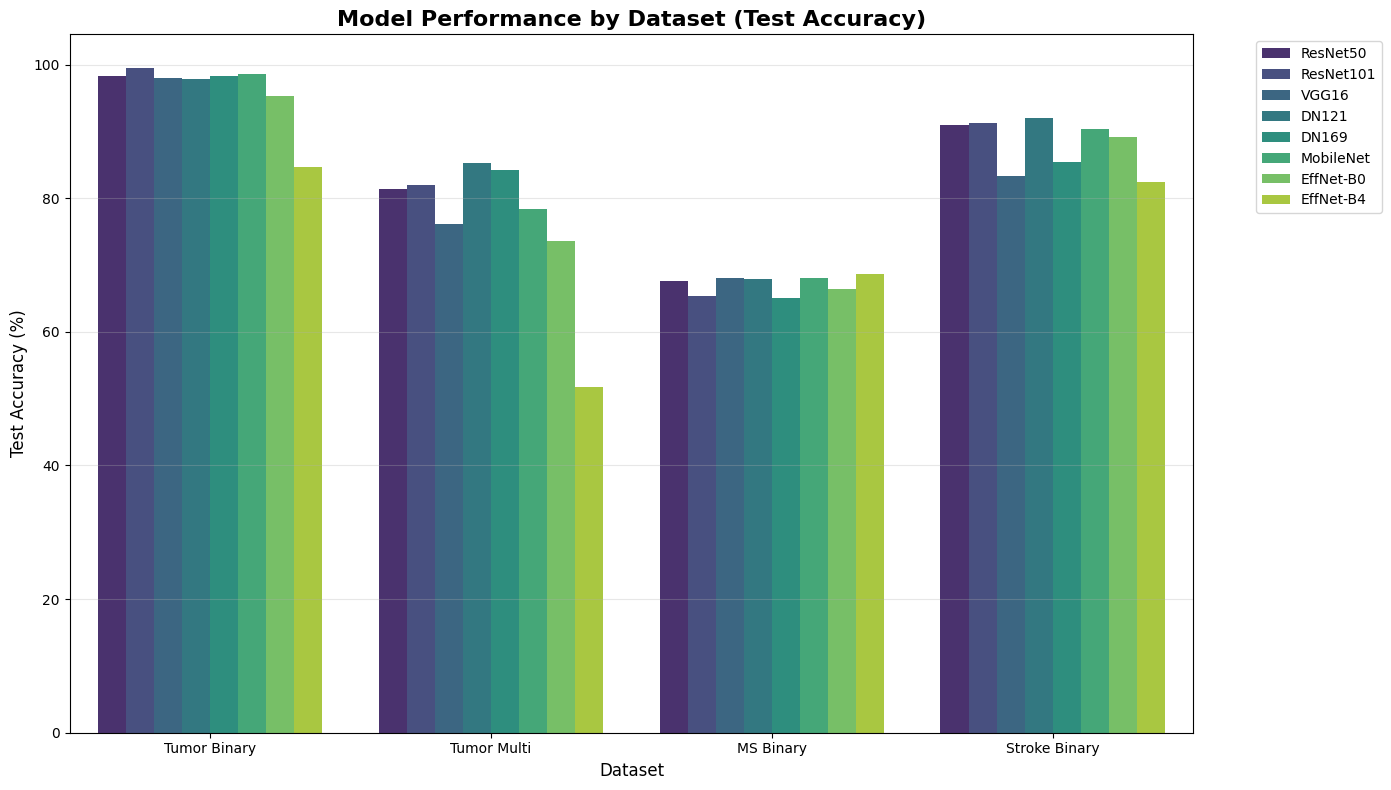

Figure 1: Accuracy Bar Chart


In [75]:
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='dataset_short', y='accuracy', hue='model_short',
            palette='viridis', dodge=True)
plt.title('Model Performance by Dataset (Test Accuracy)', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, '01_accuracy_bar.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Figure 1: Accuracy Bar Chart")

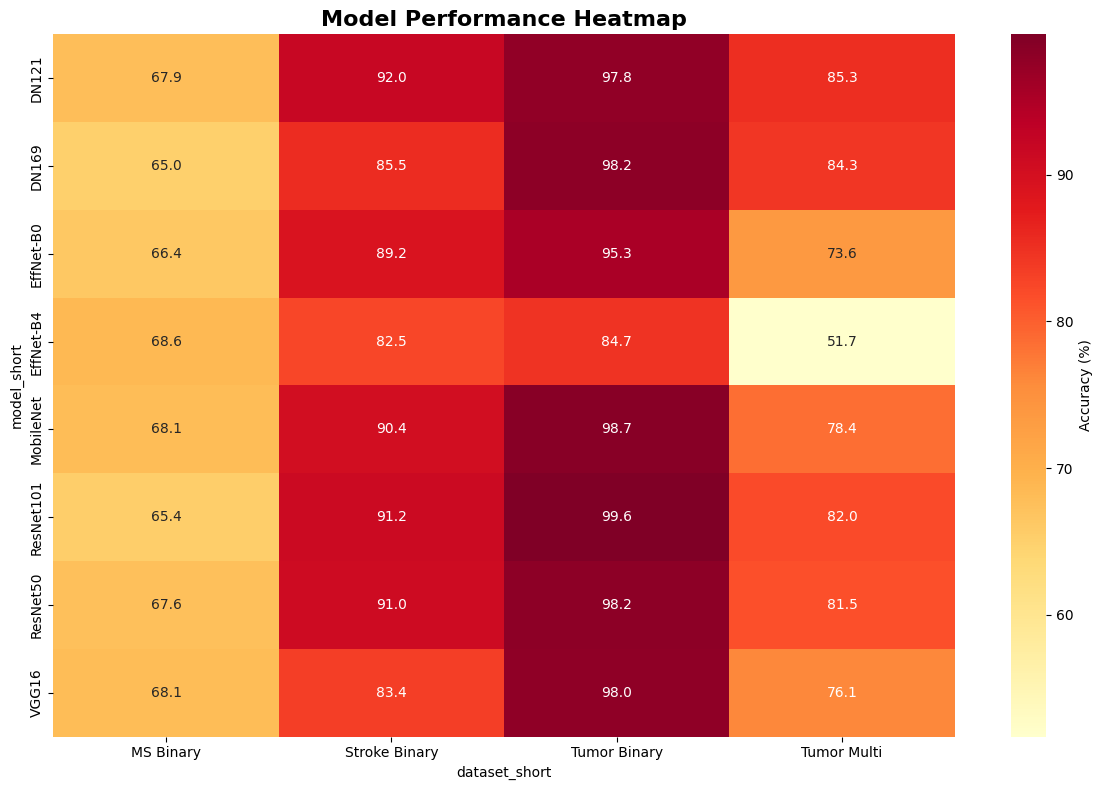

Figure 2: Performance Heatmap


In [76]:
plt.figure(figsize=(12, 8))
pivot = df.pivot(index='model_short', columns='dataset_short', values='accuracy')
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Accuracy (%)'})
plt.title('Model Performance Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, '02_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Figure 2: Performance Heatmap")

/tmp/ipython-input-2760293644.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


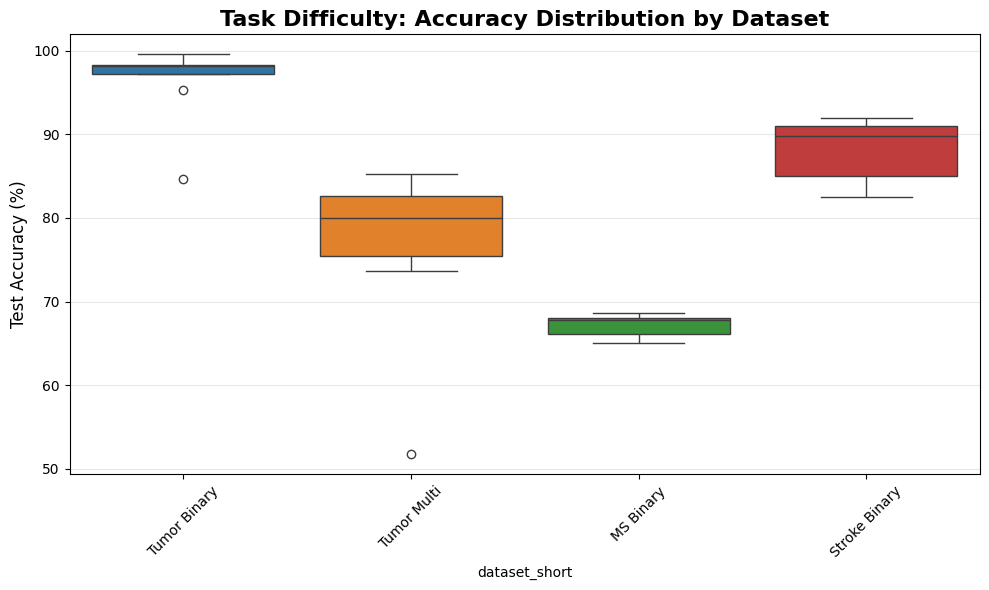

Figure 3: Task Difficulty


In [77]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='dataset_short', y='accuracy', hue='dataset_short')
plt.title('Task Difficulty: Accuracy Distribution by Dataset', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend().remove()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, '03_task_difficulty.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Figure 3: Task Difficulty")

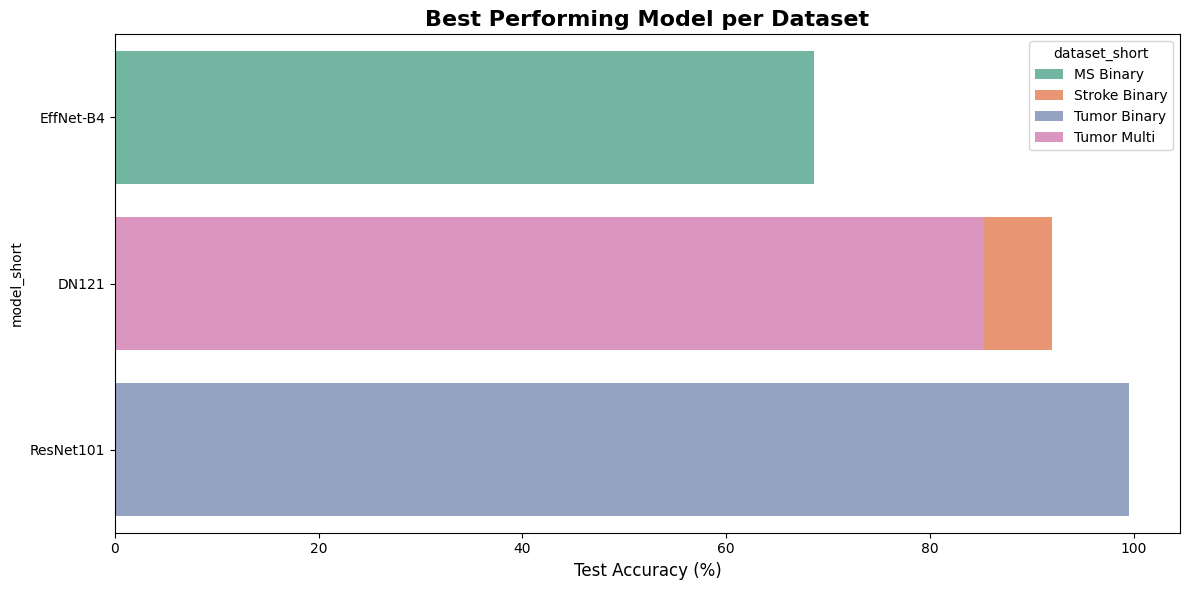

Figure 4: Best Models


In [78]:
best_models = df.loc[df.groupby('dataset_short')['accuracy'].idxmax()]
plt.figure(figsize=(12, 6))
sns.barplot(data=best_models, x='accuracy', y='model_short', hue='dataset_short',
            palette='Set2', dodge=False)
plt.title('Best Performing Model per Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Test Accuracy (%)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, '04_best_models.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Figure 4: Best Models")

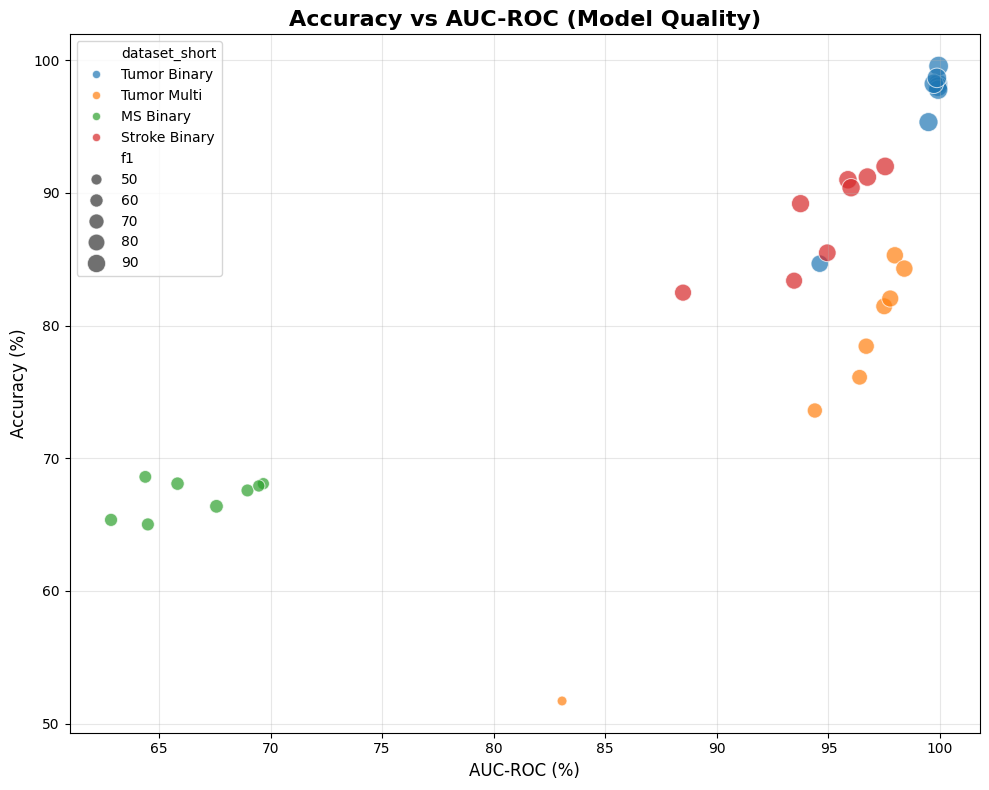

Figure 5: AUC vs Accuracy


In [79]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='auc', y='accuracy', hue='dataset_short', size='f1',
                sizes=(50, 200), alpha=0.7)
plt.title('Accuracy vs AUC-ROC (Model Quality)', fontsize=16, fontweight='bold')
plt.xlabel('AUC-ROC (%)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, '05_auc_accuracy.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Figure 5: AUC vs Accuracy")

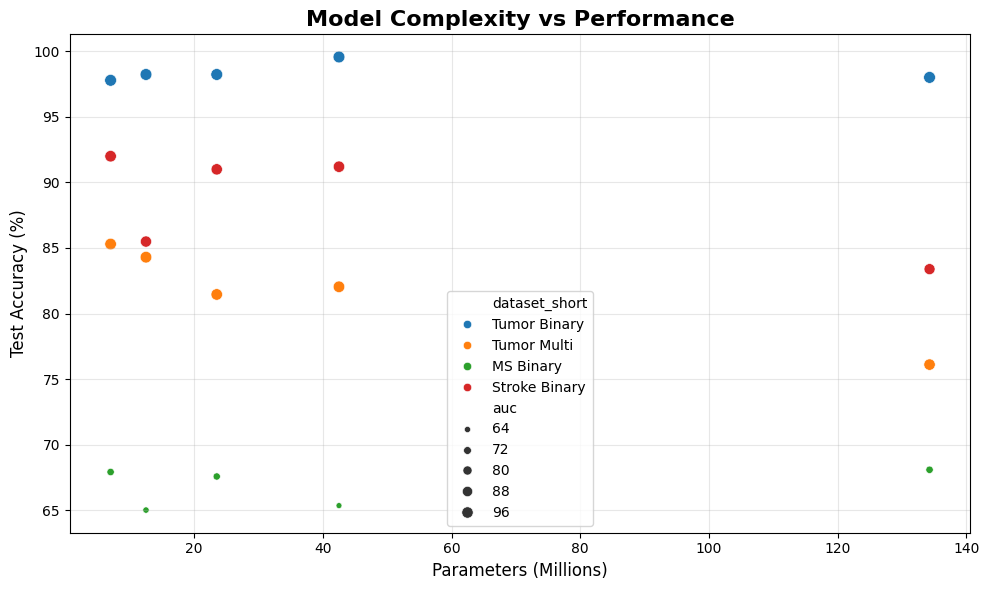

Figure 6: Complexity Tradeoff


In [80]:
model_params = {
    'resnet50': 23.5, 'resnet101': 42.5, 'vgg16': 134.3,
    'densenet121': 7.0, 'densenet169': 12.5, 'mobilenetv2': 2.3,
    'efficientnetb0': 4.0, 'efficientnetb4': 17.6
}
df['params_M'] = df['model'].map(model_params)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='params_M', y='accuracy', hue='dataset_short', size='auc')
plt.title('Model Complexity vs Performance', fontsize=16, fontweight='bold')
plt.xlabel('Parameters (Millions)', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, '06_complexity.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Figure 6: Complexity Tradeoff")